In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv("/datasets/sberbank-russian-housing-market/train.csv", index_col=0)
df_macro = pd.read_csv("/datasets/sberbank-russian-housing-market/macro.csv")

In [3]:
# dropping na's and processing ONLY for the forward stepwise
X_train.dropna(inplace=True)
X_train.reset_index(inplace=True)
X_train.drop(columns=["id"], inplace=True)
X_train = X_train.select_dtypes(include=np.number)

In [4]:
y_train = X_train[["price_doc"]]
X_train = X_train.drop("price_doc", axis = 1)

In [6]:
X_train_sample = X_train[["full_sq", "life_sq","floor"]].fillna(0).sample(5000)
y_train_sample = y_train.loc[X_train_sample.index]

In [12]:
# Entire normalized and cleaned dataset
X_train = pd.read_csv("../Data/df_train_final").drop("Unnamed: 0", axis = 1)
y_train = pd.read_csv("../Data/y_train_final").drop("Unnamed: 0", axis = 1)
X_train_normalize = (X_train - X_train.mean())/X_train.std()
y_train_normalize = (y_train - y_train.mean())/y_train.std()

X_test = pd.read_csv("../Data/df_test_final").drop("Unnamed: 0", axis = 1)
y_test = pd.read_csv("../Data/y_test_final").drop("Unnamed: 0", axis = 1)
X_test_normalize = (X_test - X_train.mean())/X_train.std()
y_test_normalize = (y_test - y_train.mean())/y_train.std()

In [13]:
X_train_sample = X_test_normalize.sample(frac=0.1)
X_test_normalize = X_test_normalize.drop(X_train_sample.index)

y_train_sample = y_test_normalize.loc[X_train_sample.index]
y_test_normalize = y_test_normalize.drop(X_train_sample.index)

## Neural Network

In [50]:
class NeuralNetwork(): 
    def fit(self, X, y, n_hidden, nodes, activations, lr, validation_X, validation_y, batch_size = 0):
        self._lr = lr
        self._X = X.values
        self._y = y.values
        self._n_hidden = n_hidden
        self._nodes = nodes
        self._weights = self._generate_weights()
        self._biases = self._generate_bias()
        self._activations = activations
        self._forward_inputs = []
        self._val_X = validation_X.values
        self._val_y = validation_y.values
        self._batch_size = batch_size
        

        return self._train()
    
    def predict(self, X):
        pred = X
        weights = self._weights
        biases = self._biases
        activations = self._activations[1:-1]
    
        for idx, layer in enumerate(weights):
            if idx == (len(weights) - 1):
                pred = (pred @ layer) + biases[idx].T,
            else:
                weight_output = (pred @ layer) + biases[idx].T
                pred = self._activation(data = weight_output, activation = activations[idx])

        return pred[0]
        
    def _activation(self, data, activation = "relu"):
        if activation == "relu":
            def relu(data):
                return np.array([max(0,i) for i in data]).reshape(data.shape)
            return np.apply_along_axis(relu, 1, data)
        if activation == "sigmoid":
            def sigmoid(data):
                return (1/(1 + np.exp(-data))).reshape(data.shape)
            return np.apply_along_axis(sigmoid, 1, data)
    
    def _der_activation(self, points, activation = "relu"):
        if activation == "relu":
            def d_relu(point):
                return np.array([0 if y <= 0 else 1 for y in point])
            return np.apply_along_axis(d_relu, 1, points)
        if activation == "sigmoid":
            ## todo
            return
    
    def _loss_function(self, ypred, loss = "l2"):
        y = self._val_y
        if loss == "mse":
            return ((ypred - y) ** 2).mean()
        if loss == "l2":
            return (((ypred - y) ** 2)/2).mean()
    
    def _loss_jacobian(self, ypred, loss = "l2"):
        if self._batch_size > 0:
            y = self._batchy
        else:
            y = self._y
        if loss == "l2":
            return (ypred - y)/(len(ypred))
    
    def _generate_weights(self):
        hidden_weights = []
        nodes = self._nodes
        for idx in range(1,len(nodes)):
            hidden_weights.append(0.1 * np.random.randn(nodes[idx -1], nodes[idx]))
            #hidden_weights.append(0.01 *np.random.randn(nodes[idx -1], nodes[idx]))

        return hidden_weights
    
    def _generate_bias(self):
        hidden_layers = []
        nodes = self._nodes
        for i in range(self._n_hidden + 1):
            hidden_layers.append(np.zeros((nodes[i + 1], 1)))
        return hidden_layers
    
    
    def _forward_propagation(self):
        """
        Suppose 2 observations
        
        Suppose previous layer is 3 nodes
        Suppose current layer is 2 nodes
        
        prev shape (2,3)
        prev = ob1 [prev_node_1 val, prev_node_2 val, prev_node_3 val]
               ob2 [prev_node_1 val, prev_node_2 val, prev_node_3 val]
               
        layer shape (3,2)
        layer = [weight for current_node_1 for prev_node_1, weight for current_node_2 for prev_node_1]
                [weight for current_node_1 for prev_node_2, weight for current_node_2 for prev_node_2]
                [weight for current_node_1 for prev_node_3, weight for current_node_2 for prev_node_3]
                
        output shape (2,2) # since 2 observations and 2 layers
        output = ob1 [current_node_1 val, current_node_2 val]
                 ob2 [current_node_1 val, current_node_2 val]
                 
        Then for bias in current layer it is (2,1) since 2 nodes in current layer
        
        So for each row in output we add the bias row wise and apply the activation function to each row
        
        prev <- ouput
        
        Move onto next layer...
        """
        if self._batch_size > 0:
            prev = self._batchX
        else:
            prev = self._X
        weights = self._weights
        biases = self._biases
        activations = self._activations[1:-1]
    
        for idx, layer in enumerate(weights):
            if idx == (len(weights) - 1):
                self._forward_inputs.append((prev, None))
                prev = (prev @ layer) + biases[idx].T,
            else:
                weight_output = (prev @ layer) + biases[idx].T
                self._forward_inputs.append((prev, weight_output))
                prev = self._activation(data = weight_output, activation = activations[idx])

        return prev
    
    def _backward_propagation(self, ypred):
            
        j = self._loss_jacobian(ypred)
                
        for i in range(len(self._forward_inputs)-1, -1, -1):
            if i != (len(self._forward_inputs) - 1):
                # activation func on all layers except the last
                der_acti = self._der_activation(self._forward_inputs[i][1])
                j = np.multiply(j,der_acti)

            x = self._forward_inputs[i][0]

            jw = x.T.dot(j)

            b = np.ones((j.shape[0],1))
            jb = j.T.dot(b)
            
            j = j.dot(self._weights[i].T)
            
            self._weights[i] -= self._lr * jw
            self._biases[i] -= self._lr * jb
            
        self._forward_inputs = []        
    
    def _train(self):
        min_loss = old_loss = np.inf
        losses = []
        mses = []
        tol = 0.00001
        terminate_count = anneal_count = 0
        while True:
            if self._batch_size > 0:
                X_index = np.arange(self._X.shape[0])
                np.random.shuffle(X_index)
                batch_index = X_index[:self._batch_size]
                self._batchX = self._X[batch_index,:]
                self._batchy = self._y[batch_index,:]
            
            batched_out = self._forward_propagation()
            validation_out = self.predict(self._val_X)
                
            loss = self._loss_function(validation_out)
            mse = self._loss_function(validation_out, loss = "mse")
            print("\nloss:")
            print(loss)
            print("mse:")
            print(mse)
            if loss <= min_loss:
                min_loss = loss
                terminate_count = anneal_count = 0
            if loss <= old_loss:
                 anneal_count = 0
                print("INCREASE IN LOSS")
            else:
                terminate_count += 1
                anneal_count += 1
                print("INCREASE IN LOSS")
                if anneal_count >= 2:
                    anneal_count = 0
                    self._lr = self._lr / 2
                    print("Decreasing learning rate. New rate is " + str(self._lr))
                if terminate_count > 20 or self._lr < tol:
                    break
            
            losses.append(loss)
            mses.append(mse)
            self._backward_propagation(batched_out[0])
            old_loss = loss
            
        return losses, mses

In [62]:
INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.5
nodes = [INPUT_SIZE,50,OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]

nn = NeuralNetwork()

losses, mses = nn.fit(X = X_train_normalize,
       y = y_train_normalize,
       n_hidden = len(nodes) - 2,
       nodes = nodes,
       activations = activations,
       lr = LEARNING_RATE,
       validation_X = X_train_sample,
       validation_y = y_train_sample,
       batch_size = 0)


loss:
0.6522860317227002
mse:
1.3045720634454003

loss:
0.5617899533033948
mse:
1.1235799066067895

loss:
0.6081912607809744
mse:
1.2163825215619488
INCREASE IN LOSS

loss:
0.9233543270380938
mse:
1.8467086540761877
INCREASE IN LOSS
Decreasing learning rate. New rate is 0.25

loss:
0.4142724861558191
mse:
0.8285449723116382

loss:
0.38737863655968563
mse:
0.7747572731193713

loss:
0.36896433063677053
mse:
0.7379286612735411

loss:
0.3564472711874229
mse:
0.7128945423748458

loss:
0.3479192556350571
mse:
0.6958385112701142

loss:
0.3416604243252234
mse:
0.6833208486504468

loss:
0.3367696743879446
mse:
0.6735393487758892

loss:
0.332920780699344
mse:
0.665841561398688

loss:
0.3298252667304897
mse:
0.6596505334609793

loss:
0.3274537652647585
mse:
0.654907530529517

loss:
0.3255927080818482
mse:
0.6511854161636964

loss:
0.3240636368161275
mse:
0.648127273632255

loss:
0.32281507865162906
mse:
0.6456301573032581

loss:
0.3217828660601582
mse:
0.6435657321203164

loss:
0.320854961472507

KeyboardInterrupt: 

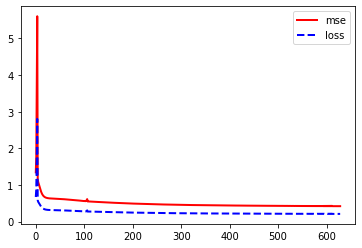

In [30]:
# RMSEs
plt.plot(range(0,len(mses)), mses, color='red', linewidth=2, label="mse")
plt.plot(range(0,len(mses)), losses, color='blue', linewidth=2, linestyle='dashed', label="loss")
plt.legend()

In [37]:
min(mses) # 1x50, 500 batch, validation, lr=0.5

0.5545446573100815

In [34]:
min(mses) # 1x50, 100 batch, validation, lr=0.5

0.53332650909424

In [31]:
min(mses) # 1x50, no batch, validation, lr=0.5

0.42089988591625715

In [59]:
min(mses) # 5x50, no batch, lr=0.5

0.30592902612462475

In [ ]:
# GRID SEARCH
INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.5


batch_size_param = [32, 64, 128, 512, 1024, 2048, 5000, 10000]
width_param = [50, 75, 100]
depth_param = [3, 5, 7, 8, 9, 10]

for batch in batch_size_param:
    for width in width_param:
        for depth in depth_param:
            
            nodes = [INPUT_SIZE] + [width for i in range(depth)] + [OUTPUT_SIZE]
            activations = ["relu" for i in range(len(nodes))]

            nn = NeuralNetwork()

            losses, mses = nn.fit(X = X_train_normalize,
                   y = y_train_normalize,
                   n_hidden = len(nodes) - 2,
                   nodes = nodes,
                   activations = activations,
                   lr = LEARNING_RATE,
                   validation_X = X_train_sample,
                   validation_y = y_train_sample,
                   batch_size = batch)
        
        print((batch, width, depth))
        print(min(mses))
        plt.figure()
        plt.plot(range(0,len(mses)), mses, color='red', linewidth=2, label="mse")
        plt.plot(range(0,len(mses)), losses, color='blue', linewidth=2, linestyle='dashed', label="loss")
        plt.legend()

In [5]:
def solve_for_B(x, y, n):
    # takes a data frame, and a numpy array
    x = np.concatenate((np.ones((n,1)), x.to_numpy()), axis=1)
    x_transpose = np.transpose(x)
    return np.linalg.solve(np.matmul(x_transpose, x), x_transpose @ y)

def get_predicted_values(beta, design_matrix, n):
    return np.matmul(np.concatenate((np.ones((n,1)), design_matrix), axis = 1), beta)

def BIC(predictions, actuals, d, n):
    # numpy array - predictions, numpy array - actual 
    return (np.square(actuals - predictions).sum()) + (d * np.log(n))

def RSquaredAdj(predictions, actuals, d, n):
    x1 = np.square(actuals - actuals.mean()).sum()
    x2 = np.square(predictions - actuals.mean()).sum()
    r2 = x2/x1
    return (1 - ((1 - r2) * (n - 1) / (n - d - 1)))

def RMSE(predictions, actuals, n):
    return np.sqrt((np.square(actuals - predictions).sum()) / n) 

def train_model(design_matrix, dependent_variable_series):
    n = design_matrix.shape[0]
    beta = solve_for_B(design_matrix, dependent_variable_series, n)
    predicted_values = get_predicted_values(beta, design_matrix, n)
    calculated_BIC = BIC(predicted_values, dependent_variable_series, d = design_matrix.shape[1], n = n)
    calculated_RMSE = RMSE(predicted_values, dependent_variable_series, n = n)
    residuals = predicted_values - dependent_variable_series
    return beta, calculated_BIC, calculated_RMSE, residuals

In [6]:
def train_crossv_model(df, y): 
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(.25 * m)
    train_1 = df.iloc[perm[:train_end]]
    test_1 = y.iloc[perm[:train_end]]

    train_2 = df.iloc[perm[train_end:train_end*2]]
    test_2 = y.iloc[perm[train_end:train_end*2]]

    train_3 = df.iloc[perm[train_end*2:train_end*3]]
    test_3 = y.iloc[perm[train_end*2:train_end*3]]

    train_4 = df.iloc[perm[train_end*3:]]
    test_4 = y.iloc[perm[train_end*3:]]
    return train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4


def get_average_RMSE_for_one_model(df, y):
    train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4 = train_crossv_model(df, y)

    beta4, bic4, RMSE4, _ = train_model(train_1.append([train_2, train_3]), test_1.append([test_2, test_3]))

    beta2, bic3,RMSE2, _ = train_model(train_1.append([train_4, train_3]), test_1.append([test_4, test_3]))

    beta3, bic2, RMSE3, _ = train_model(train_1.append([train_2, train_4]), test_1.append([test_2, test_4]))

    beta1, bic1, RMSE1, _ = train_model(train_4.append([train_2, train_3]), test_4.append([test_2, test_3]))

    return sum([RMSE1, RMSE2, RMSE3, RMSE4]) / 4, sum([bic1, bic2, bic3, bic4]) / 4


In [7]:
# forward cross validated stepwise

train_data = X_train.copy()
df_with_col = pd.DataFrame()

#min_RMSE, min_bic = get_average_RMSE_for_one_model(train_data, y_train_sample)

col_added = []
rmses = []

for i in range(0,50):

    min_col = None
    min_RMSE = 100000000000000000000
    min_bic = 10000000000000000000

    for col in train_data.columns:

        df_with_col[col] = train_data[col]
        
        new_RMSE, new_bic = get_average_RMSE_for_one_model(df_with_col, y_train)
                
        if new_RMSE[0] <= min_RMSE:
            min_bic = new_bic[0]
            min_RMSE = new_RMSE[0]
            min_col = col
            
        df_with_col.drop(columns=[col], inplace=True)

    if min_col is not None:
        print(min_col)
        df_with_col[min_col] = train_data[min_col]
        train_data.drop(columns=[min_col], inplace=True)
        rmses.append(min_RMSE)
        print("bic: " + str(min_bic))
        print("rmse: " + str(min_RMSE))
        col_added.append(min_col)
        print("")
    else:
        print("Failed #2")


full_sq
bic: 9.626303946636282e+16
rmse: 4606838.482945066

office_sqm_5000
bic: 9.236088392607434e+16
rmse: 4509890.259458901

church_count_500
bic: 8.745980531475309e+16
rmse: 4390793.45502309

prom_part_2000
bic: 8.511633546360696e+16
rmse: 4333342.953272082

kitch_sq
bic: 8.310655887323078e+16
rmse: 4281289.175857935

life_sq
bic: 8.215130287457203e+16
rmse: 4254329.778610688

leisure_count_1000
bic: 8.161106327089005e+16
rmse: 4236389.35523205

big_church_count_1500
bic: 8.058786114158811e+16
rmse: 4215470.631885044

mosque_km
bic: 7.944348729565469e+16
rmse: 4185852.331020752

cafe_count_1500_price_1500
bic: 7.896509252549352e+16
rmse: 4169259.28286633

office_sqm_1500
bic: 7.847669871204554e+16
rmse: 4160174.121158242

cafe_count_5000
bic: 7.824552931615512e+16
rmse: 4152199.015860779

office_count_3000
bic: 7.778728666210142e+16
rmse: 4142233.1379193245

cafe_count_500_price_4000
bic: 7.692101040364656e+16
rmse: 4116071.3189909803

green_part_2000
bic: 7.674373145853638e+16
rms

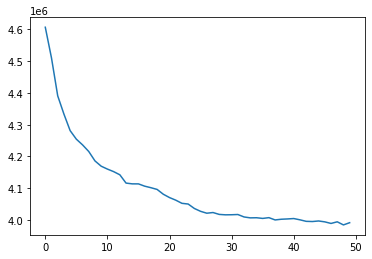

In [9]:
# RMSEs
plt.plot(range(0,50), rmses)

In [10]:
col_added

['full_sq',
 'office_sqm_5000',
 'church_count_500',
 'prom_part_2000',
 'kitch_sq',
 'life_sq',
 'leisure_count_1000',
 'big_church_count_1500',
 'mosque_km',
 'cafe_count_1500_price_1500',
 'office_sqm_1500',
 'cafe_count_5000',
 'office_count_3000',
 'cafe_count_500_price_4000',
 'green_part_2000',
 'build_count_mix',
 'floor',
 'male_f',
 'build_count_1971-1995',
 'num_room',
 'leisure_count_1500',
 'state',
 'fitness_km',
 'hospital_beds_raion',
 'leisure_count_2000',
 'cafe_count_1000_price_500',
 'cafe_count_2000_na_price',
 'cafe_count_3000_price_4000',
 'public_transport_station_min_walk',
 'ttk_km',
 'office_sqm_3000',
 'big_church_km',
 'office_sqm_2000',
 'workplaces_km',
 'green_part_1500',
 'water_km',
 'preschool_quota',
 'catering_km',
 'prom_part_1000',
 'market_count_500',
 'school_quota',
 'office_sqm_1000',
 'cafe_count_5000_price_2500',
 'cafe_avg_price_500',
 'cafe_count_5000_price_1500',
 'radiation_km',
 'trc_sqm_1000',
 'church_count_2000',
 'young_female',
 'b